This notebook presents the application of Differential Evolution to the problem of optimally controlling the 
stretcher parameters of the L1 pump Laser. In particular, in this notebook, various loss functions are experimented in the sake of identifying the one yielding the optimal pulse shape. 

Author: Francesco Capuano, 2022 S17 summer intern @ ELI-beamlines, Prague

# Setting
The goal of this project is to maximise second-harmonic efficiency. 

However, since this metric is also very much related to the shortest possible pulse shape, we developed a strategy to optimise a predefinite set of control parameters so as to minimise the difference between the obtained pulse shape (in the temporal domain) and a target one (which is, by default, the shortest one).

This process is very much intensive for what concerns the number of function evaluation we needed to use and, because of that, we resorted to use a custom-built fast-running forward model used to approximate/predict the temporal  profile of the pulse given a set of parameters. 

In particular, if one indicates with $\psi = \big( d_1, d_2, d_3 \big)$ the control configuration of the stretcher and with $E(\nu)$ the electric field in the frequency domain of the signal considered, then the fast running model we developed approximates $ \tilde{\tau}(\psi; E(\nu)) $, hopefully similar enough to the actual ${\tau}(\psi; E(\nu))$ that can be collected only through practical observation on the real hardware. 

If one has a target temporal profile $\tau^*$ of the pulse then it the problem can be framed as: 

$$\min_{\psi} L\big[ \tilde{\tau}(\psi; E(\nu)), \tau^*\big]$$

With $L$ being some sort of loss function. 

In our experiments among six different loss functions, the one that showed a better performance is Loss3, i.e.

$$
L\big[ \tilde{\tau}(\psi; E(\nu)), \tau^*\big] = 0.3 \frac{\Vert \tilde{\tau}(\psi) - \tau^* \Vert_{n < N} ^2 }{n} + 0.7 \bigg(\int_{-\infty}^{\infty} (\tilde{\tau}(\psi) - \tau^*) dt \bigg)
$$

In [1]:
# these imports are necessary to import modules from directories one level back in the folder structure
import sys
sys.path.append("../..")

from bayes_opt import BayesianOptimization
from algorithms.L1_DifferentialEvolution import extract_data, model, diff_evolution
from utils import physics
from utils.losses import Losses
from scipy.optimize import Bounds
import numpy as np
import matplotlib.pyplot as plt

Here all the necessary elemets are imported. 
Please once more note that in this case the full tunable range for GDD, TOD and FOD is used instead of the one deriving from expert-rule around the possibility of changing these parameters into a credible region. 

In [2]:
frequency, intensity = extract_data() # extracting the desired information

# compressor parameters - obtained as minus the stretcher one - TO BE FIXED WITH REAL ONES ONCE THEY ARE AVAILABLE
COMPRESSOR = -1 * np.array((267.422 * 1e-24, -2.384 * 1e-36, 9.54893 * 1e-50)) # in s^2, s^3 and s^4 (SI units)
# non linearity parameter
B = 2
# cutoff frequencies, in THz, used to remove noise - derived from visual inspection
CUTOFF = (289.95, 291.91)
# model instantiation
l1_pump = model(frequency, intensity, COMPRESSOR, B, CUTOFF, num_points=int(5e3))

losses = Losses(l1_pump)

bounds_DE = Bounds(
            # GDD         # TOD          # FOD
    lb = (2.3522e-22, -1.003635e-34, 4.774465e-50),
    ub = (2.99624e-22, 9.55955e-35, 1.4323395e-49)
)

bounds_matrix = np.vstack((bounds_DE.lb, bounds_DE.ub)).T
disp_bounds = np.sort(l1_pump.translate_control(bounds_matrix, verse = "to_disp"))

In this case an extensive hyperparameter tuning is carried out using **Bayesian Optimisation** itself around the parameters of the Differential Evolutionary algorithm. 

In [3]:
def outer_objfunc(mutation:float, cross_p:float, population_size:float) -> float: 
    """
    This is the outher objective function which is taking as input values characteristic of the 
    optimisation process.
    For further documentantion on the relevance of these parameters and their effect on the optimisation 
    route check literature.
    """
    population_size = int(population_size) # must be int
    
    candidate_best = diff_evolution(
        objective_function = losses.loss3,
        bounds = disp_bounds,
        mutation = mutation, 
        cross_p = cross_p, 
        population_size = population_size,
        verbose = 0, 
        maxit = 500, 
        print_every = 50
    )
    
    return -1 * losses.loss3(candidate_best) # maximizing

In [4]:
params_bounds = {
    "mutation": (0.5, 1.99), 
    "cross_p": (0, 1), 
    "population_size": (10, 50)
}

optimizer = BayesianOptimization(
    f = outer_objfunc, 
    pbounds = params_bounds, 
    random_state = 10, 
    verbose = 1
)

n_init, n_iter = 20, 100
optimizer.maximize(init_points = n_init, n_iter = n_iter)

|   iter    |  target   |  cross_p  | mutation  | popula... |
-------------------------------------------------------------
|  1        | -2.026    |  0.7713   |  0.5309   |  35.35    |
|  2        | -2.026    |  0.7488   |  1.243    |  18.99    |
|  3        | -2.028    |  0.1981   |  1.633    |  16.76    |
|  4        | -2.077    |  0.08834  |  1.521    |  48.14    |
|  5        | -2.23     |  0.003948 |  1.263    |  42.5     |
|  6        | -2.026    |  0.6125   |  1.575    |  21.68    |
|  7        | -2.026    |  0.9178   |  1.565    |  31.7     |
|  8        | -2.228    |  0.1422   |  1.056    |  36.97    |
|  9        | -2.026    |  0.4418   |  1.147    |  34.71    |
|  10       | -2.026    |  0.5131   |  1.469    |  34.04    |
|  11       | -2.026    |  0.8052   |  1.277    |  46.35    |
|  12       | -2.026    |  0.3192   |  0.6348   |  22.03    |
|  13       | -2.307    |  0.114    |  1.735    |  11.88    |
|  14       | -2.026    |  0.6263   |  1.316    |  42.77    |
|  15   

|  80       | -2.026    |  0.8029   |  1.975    |  24.51    |
|  81       | -2.026    |  0.9288   |  1.688    |  32.44    |
|  82       | -2.026    |  0.8681   |  1.779    |  33.11    |
|  83       | -2.026    |  0.6455   |  1.986    |  22.95    |
|  84       | -2.179    |  0.0      |  1.433    |  21.41    |
|  85       | -2.026    |  0.9487   |  0.6064   |  21.67    |
|  86       | -2.026    |  0.2986   |  0.5018   |  20.44    |
|  87       | -2.026    |  0.9865   |  1.093    |  21.35    |
|  88       | -2.026    |  0.8599   |  0.5997   |  19.71    |
|  89       | -2.038    |  0.08449  |  0.5718   |  23.21    |
|  90       | -2.026    |  0.2105   |  0.9669   |  23.3     |
|  91       | -2.166    |  0.02118  |  0.7438   |  23.49    |
|  92       | -2.026    |  0.5854   |  1.398    |  20.56    |
|  93       | -2.026    |  0.5935   |  1.391    |  23.31    |
|  94       | -2.026    |  0.7864   |  1.122    |  34.77    |
|  95       | -2.227    |  0.4086   |  1.332    |  12.11    |
|  96   

In [11]:
cross_p, mutation, pop_size = optimizer.max["params"].values()
# training with the best parameters and increased number of iterations
candidate_best = diff_evolution(
        objective_function = losses.loss3,
        bounds = disp_bounds,
        mutation = mutation, 
        cross_p = cross_p, 
        population_size = int(pop_size),
        verbose = 1, 
        maxit = 1000, 
        print_every = 50
)

Iteration 0 - Objective Function value: 54.393340247772294
Iteration 50 - Objective Function value: 2.025921707167842
Iteration 100 - Objective Function value: 2.025921629979364
Iteration 150 - Objective Function value: 2.0259216299793557
Iteration 200 - Objective Function value: 2.025921629979329
Iteration 250 - Objective Function value: 2.0259216299793255
Iteration 300 - Objective Function value: 2.0259216299793255
Iteration 350 - Objective Function value: 2.0259216299793255
Iteration 400 - Objective Function value: 2.0259216299793255
Iteration 450 - Objective Function value: 2.0259216299793255
Iteration 500 - Objective Function value: 2.0259216299793255
Iteration 550 - Objective Function value: 2.0259216299793255
Iteration 600 - Objective Function value: 2.0259216299793255
Iteration 650 - Objective Function value: 2.0259216299793255
Iteration 700 - Objective Function value: 2.0259216299793255
Iteration 750 - Objective Function value: 2.0259216299793255
Iteration 800 - Objective Func

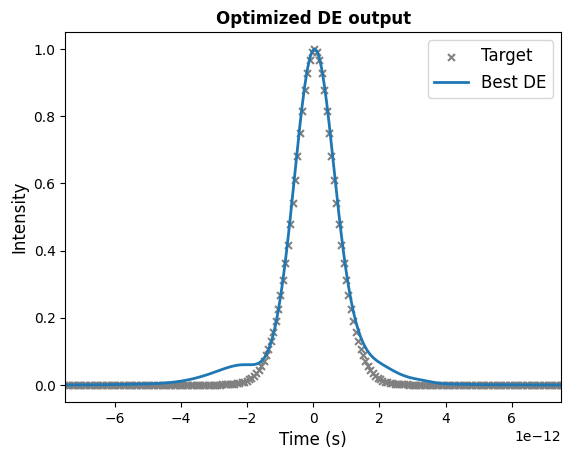

In [26]:
time, profile = l1_pump.forward_pass(candidate_best)
fig, ax = plt.subplots()

ax.set_title("Optimized DE output", fontweight = "bold")
ax.scatter(losses.target_time, losses.target_profile, marker = "x", c = "grey", s = 25, label = "Target")
ax.plot(losses.target_time, np.roll(profile, - np.argmax(profile) + np.argmax(losses.target_profile)), label = "Best DE", lw = 2)

ax.set_xlim(-7.5e-12, 7.5e-12); ax.set_xlabel("Time (s)", fontsize = 12); ax.set_ylabel("Intensity", fontsize = 12)
ax.legend(fontsize = 12)
plt.show()
